✅ Google Collab was picked in order to use T4 Tesla CPU and to be able to read daps set from the Google drive due to the local computer limitations. Also it is perfect for work in cooperation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ Installing all the dependencies needed.

In [2]:
!pip install noisereduce

In [3]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [5]:
!pip install torchaudio

✅ import all the needed libraries

In [33]:
import joblib

In [6]:
import torchaudio
from torchaudio.transforms import Resample

In [7]:
import os
import time
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from collections import Counter
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import noisereduce as nr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch.nn.utils.prune as prune

In [38]:
# classic ML imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

** ❗BLOCK OF FUNCTIONS❗  DATA PREPROCESSING  **

✅  Recursively collecting all .wav files in the directory and its subdirectories.
The directory is set further in main

In [8]:
def get_wav_files(wav_dir):
    wav_files = []
    for root, dirs, files in os.walk(wav_dir):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    print(f"Total .wav files found: {len(wav_files)}")
    return wav_files

✅ Reducing the noise in the audios

In [9]:
def apply_noise_reduction(y, sr=16000):
    reduced_noise_audio = nr.reduce_noise(y=y, sr=sr)
    return reduced_noise_audio

✅ Loading the audio from the provided path, checking the length as a part of debugging

In [10]:
def load_audio(file_path,sr=16000):
    try:
      y, sr = librosa.load(file_path, sr=sr)
      print(f"Loaded {file_path}, Audio Length: {len(y)}")
      return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

✅ Cleaning the audio: trimming silence, cutting to universal length (will be set further in main)

In [11]:
def clean_audio(y,sr,file_path, trim_silence=True, cut_length=None):
    try:
        y = y / np.max(np.abs(y))
        if trim_silence:
            y, _ = librosa.effects.trim(y, top_db=20)
            print(f"Trimmed silence from {file_path}, Audio Length after trimming: {len(y)}")
        if cut_length:
            y = y[:int(sr * cut_length)]
            print(f"Cut {file_path} to {cut_length} seconds, Final Length: {len(y)}")
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None


✅ Loading and cleaning in one fucntion

In [12]:
def load_and_clean_audio(file_path, sr=16000, trim_silence=True, cut_length=None, error_files=None):

    try:
        waveform, sr_native = torchaudio.load(file_path)
        print(f"Loaded {file_path}, Native Sampling Rate: {sr_native}, Shape: {waveform.shape}")

        if sr_native != sr:
            resampler = Resample(orig_freq=sr_native, new_freq=sr)
            waveform = resampler(waveform)
            print(f"Resampled {file_path} from {sr_native} Hz to {sr} Hz")

        y = waveform.squeeze().numpy()
        print(f"Waveform shape after squeeze: {y.shape}")

        if len(y) == 0:
            raise ValueError(f"Audio data is empty for file: {file_path}")
        y = y / np.max(np.abs(y))
        print(f"Normalized waveform, max value: {np.max(np.abs(y))}")

        if trim_silence:
            y, _ = librosa.effects.trim(y, top_db=20)
            if y is None or len(y) == 0:
                raise ValueError(f"Trimmed audio is empty for file: {file_path}")
            print(f"Trimmed silence: {file_path}, Length after trimming: {len(y)} samples")

        if cut_length:
            if len(y) < int(sr * cut_length):
                padding = int(sr * cut_length) - len(y)
                y = np.pad(y, (0, padding))
                print(f"Padded {file_path} to {cut_length} seconds, Final Length: {len(y)} samples")
            else:
                y = y[:int(sr * cut_length)]
                print(f"Cut {file_path} to {cut_length} seconds, Final Length: {len(y)} samples")
        else:
            print(f"No cut_length provided for file: {file_path}")

        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        if error_files is not None:
            error_files.append(file_path)
        return None, None

✅ Generating the spectogram

In [13]:
def generate_spectrogram(y, sr=16000, n_mels=64):
    """Generate a mel-spectrogram from the audio data."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

✅ Saving spectograms to numpy

In [14]:
def save_spectrogram_to_npy(spectrogram, original_wav_file, save_dir, processed=False):
    """Save the spectrogram to a .npy file."""
    os.makedirs(save_dir, exist_ok=True)
    file_name = os.path.basename(original_wav_file).replace('.wav', '_processed.npy') if processed else os.path.basename(original_wav_file).replace('.wav', '.npy')  # Replace .wav with .npy
    save_path = os.path.join(save_dir, file_name)
    np.save(save_path, spectrogram)
    print(f"Spectrogram saved to {save_path}")

✅ Processing all together in batches allows us in further shorten the time because of preprocessing only once and then reusing npy presaved

In [15]:
def process_audio_to_spectrograms_and_save_in_chunks(wav_dir, sr=16000, n_mels=64, cut_length=None, save_dir='/path/to/save/spectrograms'):
    """Process audio files, generate spectrograms, and save them as .npy files one at a time to avoid memory overload."""
    error_files=[]
    file_paths = get_wav_files(wav_dir)
    for i, file in enumerate(file_paths):
        npy_file_path = os.path.join(save_dir, os.path.basename(file).replace('.wav', '.npy'))
        # print(f"Checking if {npy_file_path} exists...")
        if os.path.exists(npy_file_path):
            # print(f"Skipping {file} (already processed)")
            continue
        try:
            y, sr = load_and_clean_audio(file, sr=sr, trim_silence=True, cut_length=cut_length, error_files=error_files)
            if y is None:
                continue

            spectrogram = generate_spectrogram(y, sr, n_mels)
            save_spectrogram_to_npy(spectrogram, file, save_dir)

            spectrogram = generate_spectrogram(y, sr, n_mels)
            save_spectrogram_to_npy(spectrogram, file, save_dir, processed=True)

            # Cleanup
            del y, spectrogram
            gc.collect()
        except Exception as e:
            print(f"Error processing or saving spectrogram for {file}: {e}")
        if i % 10 == 0:
            print(f"Progress: Processed {i + 1}/{len(file_paths)} files.")
    print("All spectrograms processed and saved.")


** ❗BLOCK OF FUNCTIONS❗ Some of the visualisation **

✅ Spectograms statistics visualisation

In [16]:
def calculate_spectrogram_stats(spectrograms):
    mean_list = []
    var_list = []

    for spec in spectrograms:
        mean_list.append(np.mean(spec))
        var_list.append(np.var(spec))

    print(f"Average Spectrogram Mean: {np.mean(mean_list):.4f}")
    print(f"Average Spectrogram Variance: {np.mean(var_list):.4f}")
    plt.figure(figsize=(6, 8))
    plt.subplot(2, 1, 1)
    plt.hist(mean_list, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Spectrogram Means")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Frequency")

    # Plot histogram of variances
    plt.subplot(2, 1, 2)
    plt.hist(var_list, bins=20, color='yellow', edgecolor='black')
    plt.title("Distribution of Spectrogram Variances")
    plt.xlabel("Variance in Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

✅ Confusion matrix

In [17]:
def plot_confusion_matrix(model, loader, device, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    for texts in ax.texts:
        texts.set_visible(False)

    label_texts = [
        f'TN\n{cm[0, 0]}',
        f'FP\n{cm[0, 1]}',
        f'FN\n{cm[1, 0]}',
        f'TP\n{cm[1, 1]}'
    ]

    # Positions TN, FP, FN, TP
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for pos, label in zip(positions, label_texts):
        ax.text(pos[1], pos[0], label, ha='center', va='center', color='white' if cm[pos[0], pos[1]] > cm.max() / 2 else 'black', fontsize=12, fontweight='bold')
    plt.title("Confusion Matrix with TN, FP, FN, TP Labels")
    plt.show()

✅ Tracking Most and Least Difficult Samples - Sorting by Loss - Taking first 5 and last 5 samples

In [18]:
def track_difficult_samples(model, loader, device, file_ids=None):
    model.eval()
    sample_difficulties = []

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = F.cross_entropy(outputs, y_batch, reduction='none')
            batch_file_ids = file_ids[i * loader.batch_size: (i + 1) * loader.batch_size] if file_ids else [None] * len(y_batch)

            for j, l in enumerate(loss.cpu().numpy()):
                sample_difficulties.append((batch_file_ids[j], l, y_batch[j].cpu().numpy()))

    # Sort samples by loss
    sample_difficulties = sorted(sample_difficulties, key=lambda x: x[1], reverse=True)
    most_difficult = sample_difficulties[:5]
    least_difficult = sample_difficulties[-5:]

    print("Most difficult samples:")
    for sample in most_difficult:
        print(f"Sample ID: {sample[0]}, Sample Class: {sample[2]}, Loss: {sample[1]:.4f}")

    print("Least difficult samples:")
    for sample in least_difficult:
        print(f"Sample ID: {sample[0]}, Sample Class: {sample[2]}, Loss: {sample[1]:.4f}")

✅ PCA transformation - of course 2D PCA is an over simplified approach but for better interpretation we would like to see it on 2D Graph - clustering with KMeans on each of 10 epochs

In [19]:
def perform_clustering_and_plot(model, loader, device, n_clusters=5):
    model.eval()
    activations = []
    labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)

            model.eval()
            x = model.pool(F.relu(model.conv1(X_batch)))
            x = model.pool(F.relu(model.conv2(x)))

            x = x.view(-1, model.fc1.in_features)
            activations.append(model.fc1(x).cpu().numpy())
            labels.extend(y_batch.cpu().numpy())
    activations = np.vstack(activations)

    pca = PCA(n_components=2)
    reduced_activations = pca.fit_transform(activations)

    # Clustering using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced_activations)

    sns.scatterplot(x=reduced_activations[:, 0], y=reduced_activations[:, 1], hue=clusters, palette="deep")
    plt.title(f"Clustering activations at Epoch")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

✅ visualising 3 (default) random spectograms

In [20]:
def visualize_spectrograms(npy_files, num_to_visualize=3):
    for i, npy_file in enumerate(npy_files[:num_to_visualize]):
        try:
            spectrogram = np.load(npy_file)
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Spectrogram of {os.path.basename(npy_file)}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error loading or visualizing {npy_file}: {e}")

✅ Recursively load all .npy files from the directory.

In [21]:
def load_npy_files(npy_dir):
    npy_files = []
    processed_npy_files = []
    for root, dirs, files in os.walk(npy_dir):
        for file in files:
            if file.endswith('processed.npy'):
                processed_npy_files.append(os.path.join(root, file))
            elif file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    print(f"Total .npy files found: {len(npy_files)}")
    return npy_files, processed_npy_files

✅ Load a spectogram from a npy

In [22]:
def load_spectrogram_from_npy(npy_file):
    try:
        spectrogram = np.load(npy_file)
        return spectrogram
    except Exception as e:
        print(f"Error loading {npy_file}: {e}")
        return None

✅ Assigning labels from npy files based on their IDs - ['F1', 'F7', 'F8', 'M3', 'M6', 'M8'] for Class 1, others for Class 0

In [23]:
def assign_labels_from_npy(files):
    """Assign class labels based on the speaker IDs in the .npy filenames."""
    class_1_speakers = ['F1', 'F7', 'F8', 'M3', 'M6', 'M8']  # Class 1
    labels = []
    for file in files:
        speaker_id = os.path.basename(file).split('_')[0].upper()
        if speaker_id in class_1_speakers:
            labels.append(1)
        else:
            labels.append(0)
    return labels

✅ Dataset

In [24]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = spectrograms
        self.labels = labels
    def __len__(self):
        return len(self.spectrograms)
    def __getitem__(self, idx):
        spectrogram = torch.tensor(self.spectrograms[idx], dtype=torch.float32).unsqueeze(0)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return spectrogram, label
        else:
            return spectrogram

** ❗BLOCK OF FUNCTIONS❗ MODELS **

✅ SimpleCNN

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.fc1 is None:
          flattened_size = x.view(x.size(0), -1).size(1)
          self.fc1 = nn.Linear(flattened_size, 128)
          self.fc1 = self.fc1.to(x.device)
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

✅ MLP Multi-layer perceptron

In [26]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
      if self.fc1 is None:
        # flattening data
        flattened_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc1 = self.fc1.to(x.device)  # to device (CPU or GPU)
      x = x.view(-1, self.fc1.in_features)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

✅ ResNet as inspiration, but a simpler one, skip-connection makes the difference

In [27]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        residual = self.downsample(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)


class ResNetSmall(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.fc1 = None  # This will be defined dynamically
        self.fc2 = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return BasicBlock(in_channels, out_channels, stride)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final classification layer
        return x

✅ training the model (as input argument) on 10 epochs, with learning_rate = 0.001

Adding the optimizer (Adam) and stepLR scheduler - together they improve the performance.
Scoring F1 with macro as 'average' on a validation set

In [28]:
def train_and_evaluate(model, train_loader, val_loader, labels, num_epochs=10, lr=0.001, n_clusters=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_weights = calculate_class_weights(labels)
    weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

    # initialise optimizer (Adam here, we can add others), scheduler, we can change criterion
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss(weight=weights)

    # train model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
        # print(f"Clustering activations after Epoch {epoch+1}")
        # perform_clustering_and_plot(model, val_loader, device, n_clusters=n_clusters)

    # Estimation on val
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # F1-score estimation
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1, model

✅ A function to run training and evaluation for multiple models given as a simple dictionary.

In [29]:
def compare_models(train_loader, val_loader, labels):
    models = {
        'SimpleCNN': SimpleCNN(),
        'MLP': MLP(),
        'ResNet': ResNetSmall()
    }
    results = {}
    best_f1 = 0.0
    best_model = None

    # Training + f1
    for model_name, model in models.items():
        print(f"\n=== Training and estimation: {model_name} ===")
        f1, current_model = train_and_evaluate(model, train_loader, val_loader, labels, num_epochs=10, lr=0.001)

        if f1 is not None and not np.isnan(f1):
            results[model_name] = f1
            print(f"{model_name}: F1-score = {f1:.4f}")

            # Comparing f1's to take the best model - in the base case we have only CNN (MLP+RF ready)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
        else:
            print(f"F1-score for {model_name} wasn't calculated correctly")
    print("\n=== Comparing models ===")
    for model_name, f1 in results.items():
        print(f"{model_name}: F1-score = {f1:.4f}")

    if best_model is None:
        raise ValueError("No valid models with valid F1-scores.")

    # Best f1 model
    return best_model

✅ Some small help functions

In [30]:
def calculate_class_weights(labels):
    """Calculate class weights based on the labels."""
    class_counts = Counter(labels)
    total_samples = sum(class_counts.values())
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    return class_weights

In [31]:
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for spectrograms, labels in loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='macro')
    return f1

✅ Saving and loading functions

In [32]:
""" Saving full model """
def save_model_neural(model, path):
    torch.save(model.state_dict(), path)

In [34]:
def save_model_classic(model, path):
    joblib.dump(model, path)
    print(f"Model saved to {path}")

In [35]:
def load_model_neural(path, model_class):
    model = model_class()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    return model

In [36]:
def load_model_classic(path):
    model = joblib.load(path)
    print(f"Model loaded from {path}")
    return model

✅ Random Forrest - deleted from the dictionary of the models to be run in the main entry point due to the time consumption and limited resources. However, it gave us 0.95 F1 which is a good result for a fairly simple model (comparing to deep neural networks like ResNet). We can assume results are good because of stable beahvior of RF to overfitting due to ensembling of many Decision Trees and subsamples bootstrapping.

➕ Advantages: Simplicity, more easy interpretaion - best_model.feature_importances_

➖ Disadvantages: required standartising, needed precise and long parameters tuning, which required usage of GridSearchCV(not our case because of the amount of features and samples and limited resources) or RandomizedSearchCV (our case)  

In [39]:
def random_forest_with_random_search(spectrograms, labels, test_size=0.2, n_iter=10, cv=3):
    # spectograms -> vectors (flattening)
    X = np.array([s.flatten() for s in spectrograms])
    y = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Standartizing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    param_distributions = {
        'criterion': ['gini', 'entropy'],
        'n_estimators': range(15,35, 5),
        'max_depth': [None, 3, 6, 9, 12, 15],
        'min_samples_split': [9,10],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [True, False]
        # things below dropped the f1 and accuracy

        # 'max_leaf_nodes': range(1,10, 2),
        # 'oob_score': [True, False]
    }
    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print(f"Лучшие параметры: {best_params}")
    best_rf = random_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"accuracy score:  {accuracy_score(y_test, y_pred)}")
    print(f"RandomForest F1-Score with best params: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for RandomForest')
    plt.show()
    return best_rf, best_params, f1

❗MAIN ❗

Basic comparison of all the models set in the dictionary of the models.
- Training on preprocessed npy's, some statistics as output (commented to preserve time and performance), scoring on validation set, scoring on a test set.
Only the best one is saved to .pth file

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
- REPLACE wav_dir with the path to your daps wav set
- REPLACE save_dir with the path to your npy spectograms set:
    - if you are starting from scratch it should be the path to an empty folder where the program will save all the newly created npy files
    - if you are using our npy's preprocessed it should be the path to the npy's preprocessed - this way the program will skip the preprocessing part and will use the ones that are already made for you  
- UNCOMMENT statistics if you have time
- REPLACE model_save_path with the path where you want to have your best model be saved


⭕⭕⭕ THE LAST OUTPUT ⭕⭕⭕

Total .wav files found: 1515

All spectrograms processed and saved.

Total .npy files found: 1500


=== Training and estimation: SimpleCNN ===

Epoch 1/10, Loss: 0.7927

Epoch 2/10, Loss: 0.5138

Epoch 3/10, Loss: 0.3962

Epoch 4/10, Loss: 0.2967

Epoch 5/10, Loss: 0.2013

Epoch 6/10, Loss: 0.1561

Epoch 7/10, Loss: 0.1457

Epoch 8/10, Loss: 0.1446

Epoch 9/10, Loss: 0.1405

Epoch 10/10, Loss: 0.1374

SimpleCNN: F1-score = 0.9467


=== Training and estimation: MLP ===

Epoch 1/10, Loss: 0.7862

Epoch 2/10, Loss: 0.7024

Epoch 3/10, Loss: 0.5487

Epoch 4/10, Loss: 0.5211

Epoch 5/10, Loss: 0.4699

Epoch 6/10, Loss: 0.4057

Epoch 7/10, Loss: 0.3720

Epoch 8/10, Loss: 0.3718

Epoch 9/10, Loss: 0.3651

Epoch 10/10, Loss: 0.3549

MLP: F1-оценка = 0.8475


=== Training and estimation: ResNet ===
Epoch 1/10, Loss: 0.3905

Epoch 2/10, Loss: 0.1317

Epoch 3/10, Loss: 0.1092

Epoch 4/10, Loss: 0.1016

Epoch 5/10, Loss: 0.0557

Epoch 6/10, Loss: 0.0123

Epoch 7/10, Loss: 0.0069

Epoch 8/10, Loss: 0.0048

Epoch 9/10, Loss: 0.0036

Epoch 10/10, Loss: 0.0029

ResNet: F1-оценка = 0.9530


=== Comparing models ===
SimpleCNN: F1-score = 0.9467
MLP: F1-score = 0.8475
ResNet: F1-score = 0.9530


Model saved to: ./best_model.pth
f1-score on validation_set (10%): 0.9530
f1-score on test_set (20%): 0.9639


Tracking most and least difficult samples on validation set:
Most difficult samples:
Sample ID: f5_script2_ipadflat_office1_processed.npy, Sample Class: 1, Loss: 4.7823
Sample ID: f2_script2_ipadflat_office1_processed.npy, Sample Class: 1, Loss: 2.1850
Sample ID: m10_script5_ipadflat_office1_processed.npy, Sample Class: 0, Loss: 1.4207
Sample ID: f5_script4_ipadflat_office1_processed.npy, Sample Class: 0, Loss: 1.3280
Sample ID: m2_script2_iphone_balcony1_processed.npy, Sample Class: 0, Loss: 1.0542
Least difficult samples:
Sample ID: f6_script2_iphone_balcony1_processed.npy, Sample Class: 0, Loss: 0.0001
Sample ID: m5_script3_iphone_balcony1_processed.npy, Sample Class: 0, Loss: 0.0001
Sample ID: m8_script3_ipadflat_office1_processed.npy, Sample Class: 0, Loss: 0.0000
Sample ID: m3_script3_iphone_balcony1_processed.npy, Sample Class: 0, Loss: 0.0000
Sample ID: m5_script1_iphone_balcony1_processed.npy, Sample Class: 0, Loss: 0.0000
Confusion Matrix on Validation Set:
--picture--


Total .wav files found: 1515
All spectrograms processed and saved.
Total .npy files found: 1500

=== Training and estimation: SimpleCNN ===
Epoch 1/10, Loss: 0.7927
Epoch 2/10, Loss: 0.5138
Epoch 3/10, Loss: 0.3962
Epoch 4/10, Loss: 0.2967
Epoch 5/10, Loss: 0.2013
Epoch 6/10, Loss: 0.1561
Epoch 7/10, Loss: 0.1457
Epoch 8/10, Loss: 0.1446
Epoch 9/10, Loss: 0.1405
Epoch 10/10, Loss: 0.1374
SimpleCNN: F1-оценка = 0.9467

=== Training and estimation: MLP ===
Epoch 1/10, Loss: 0.7862
Epoch 2/10, Loss: 0.7024
Epoch 3/10, Loss: 0.5487
Epoch 4/10, Loss: 0.5211
Epoch 5/10, Loss: 0.4699
Epoch 6/10, Loss: 0.4057
Epoch 7/10, Loss: 0.3720
Epoch 8/10, Loss: 0.3718
Epoch 9/10, Loss: 0.3651
Epoch 10/10, Loss: 0.3549
MLP: F1-оценка = 0.8475

=== Training and estimation: ResNet ===
Epoch 1/10, Loss: 0.3905
Epoch 2/10, Loss: 0.1317
Epoch 3/10, Loss: 0.1092
Epoch 4/10, Loss: 0.1016
Epoch 5/10, Loss: 0.0557
Epoch 6/10, Loss: 0.0123
Epoch 7/10, Loss: 0.0069
Epoch 8/10, Loss: 0.0048
Epoch 9/10, Loss: 0.0036


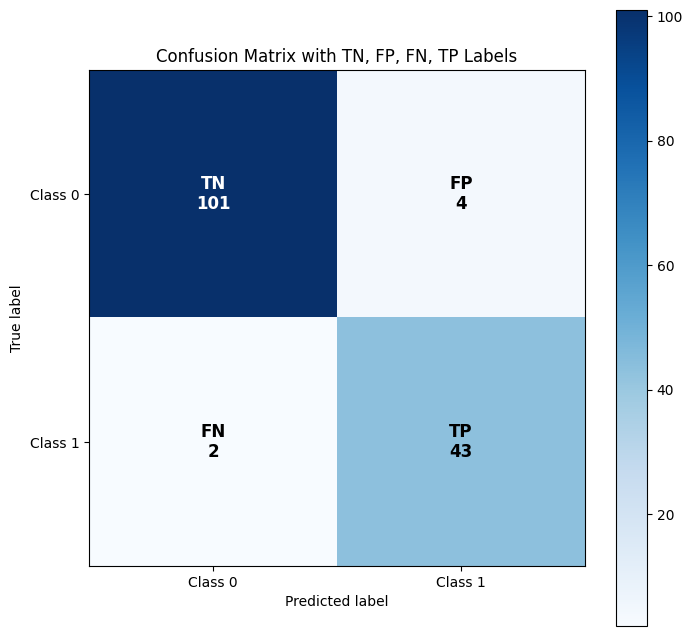

In [ ]:
if __name__ == "__main__":
    wav_dir = '/content/drive/MyDrive/voice_recognition/daps'
    save_dir = '/content/drive/MyDrive/voice_recognition/npy_spectograms_last_last'
    cut_length = 3
    n_mels = 64
    process_audio_to_spectrograms_and_save_in_chunks(wav_dir, sr=16000, n_mels=n_mels, cut_length=cut_length, save_dir=save_dir)
    npy_files, processed_npy_files = load_npy_files(save_dir)
    processed_spectrograms = [load_spectrogram_from_npy(file) for file in processed_npy_files if load_spectrogram_from_npy(file) is not None]
    raw_data_spectrograms = [load_spectrogram_from_npy(file) for file in npy_files if load_spectrogram_from_npy(file) is not None]

    labels = assign_labels_from_npy(processed_npy_files)
    # print("Statistics for Processed Spectrograms:")
    # calculate_spectrogram_stats(processed_spectrograms)
    # print("Statistics for Raw Spectrograms:")
    # calculate_spectrogram_stats(raw_data_spectrograms)
    train_val_spectrograms, test_spectrograms, train_val_labels, test_labels = train_test_split(processed_spectrograms, labels, test_size=0.2, random_state=42, stratify=labels)
    train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(train_val_spectrograms, train_val_labels, test_size=0.125, random_state=42, stratify=train_val_labels)
    # 0.125 * 80% = 10%
    train_dataset = SpectrogramDataset(train_spectrograms, train_labels)
    val_dataset = SpectrogramDataset(val_spectrograms, val_labels)
    test_dataset = SpectrogramDataset(test_spectrograms, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = compare_models(train_loader, val_loader, labels)
    model_save_path = './best_model.pth'

    save_model_neural(best_model, model_save_path)
    print(f"Model saved to: {model_save_path}")

    f1_val = calculate_f1_score(best_model, val_loader, device)
    print(f"f1-score on validation_set (10%): {f1_val:.4f}")

    f1_test = calculate_f1_score(best_model, test_loader, device)
    print(f"f1-score on test_set (20%): {f1_test:.4f}")

    file_ids = [os.path.basename(file) for file in processed_npy_files]

    print("Tracking most and least difficult samples on validation set:")
    track_difficult_samples(best_model, val_loader, device, file_ids)

    print("Confusion Matrix on Validation Set:")
    class_names = ['Class 0', 'Class 1']

    plot_confusion_matrix(best_model, val_loader, device, class_names)


❗ADVANCED CHALLENGES BLOCK ❗

❗❗❗THIS BLOCK IS NOT IN MAIN ❗❗❗

Basically, we did not want to lose the output of the main but we needed to check other models as additional tasks (Monte-Carlo and ResNet pruned). That is why the lines of code below are in separate global cells

✅ Visualising activations of individual CNN layers

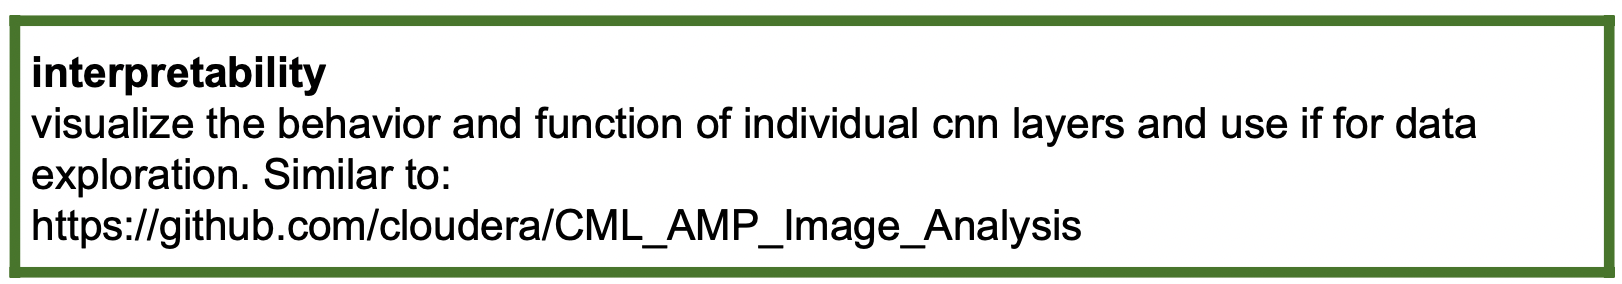

In [41]:
def visualize_cnn_layers(model, spectrogram, layer_names=None):
    """
    Visualize activations of individual CNN layers for a given input.

    Args:
    - model: Trained CNN model.
    - spectrogram: Input spectrogram (single sample).
    - layer_names: List of layer names to visualize. If None, all layers are visualized.
    """
    model.eval()
    hooks = []
    activations = {}

    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach().cpu()
        return hook

    for name, layer in model.named_modules():
        if isinstance(layer, (torch.nn.Conv2d, torch.nn.ReLU)) and (layer_names is None or name in layer_names):
            hooks.append(layer.register_forward_hook(get_activation(name)))

    spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        model(spectrogram)

    for hook in hooks:
        hook.remove()

    for name, activation in activations.items():
        num_filters = activation.size(1)  # num of filters
        size = int(np.ceil(np.sqrt(num_filters)))

        plt.figure(figsize=(15, 15))
        plt.suptitle(f"Activations: {name}", fontsize=16)
        for i in range(num_filters):
            plt.subplot(size, size, i + 1)
            plt.imshow(activation[0, i].numpy(), cmap='viridis', aspect='auto')
            plt.axis('off')
        plt.show()


✅ Taking the preprocessed .npy, giving it to the presaved neural model and further visualisation of layers - for sure simple CNN is not the best choice for this kind of visualisation (the architecture is way too simple) but for the experiment we are doing it on CNN and 2 convolutional layers.

Another point, if we had pictures more adjusted for personal analysis with human eyes (like pictures of people or cats and dogs) that visualisation would be much more informative

In [ ]:
npy_folder = '/content/drive/MyDrive/voice_recognition/npy_spectograms_last_last'
npy_files_anal, processed_npy_files_anal = load_npy_files(npy_folder)
processed_spectrograms = [load_spectrogram_from_npy(file) for file in processed_npy_files_anal if load_spectrogram_from_npy(file) is not None]

model_for_anal = load_model_neural('/content/best_model.pth') #load_model_neural already in eval mode

In [ ]:
visualize_cnn_layers(model_for_anal, processed_spectrograms[5], layer_names=['conv1', 'conv2'])

Output hidden; open in https://colab.research.google.com to view.

❗Monte-Carlo + 3 CNN ensemble - implementation here, full explanation in the report

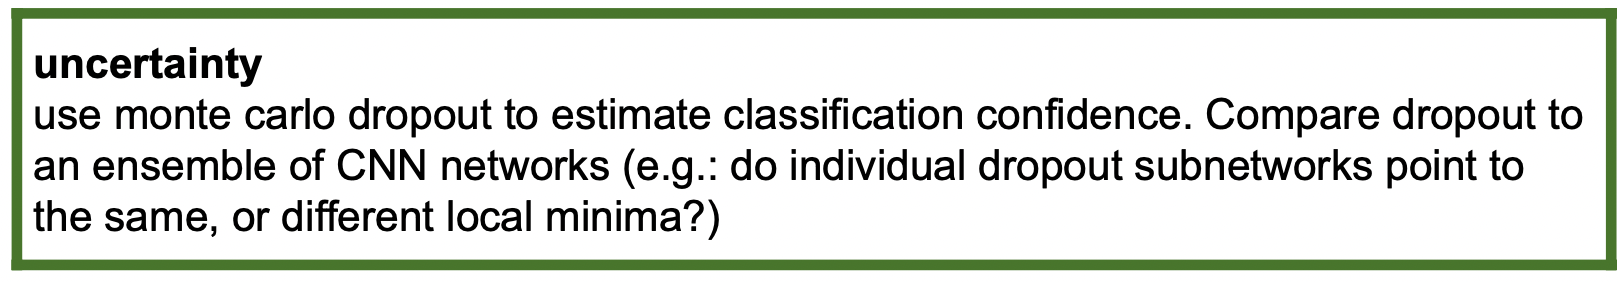

✅ CNN with a dropout

In [44]:
class SimpleCNN_MC(nn.Module):
    def __init__(self):
        super(SimpleCNN_MC, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = None
        self.fc2 = nn.Linear(128, 2)  # binary classification out

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128)
            self.fc1 = self.fc1.to(x.device)

        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

✅ mean and std of MC CNN

In [45]:
def mc_dropout_dataset(model, data_loader, T=100):

    model.train()  # Dropout on
    all_means = []
    all_stds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(next(model.parameters()).device)
            batch_preds = []

            # T stochastic forward passes - in training we're trying T=1000 which increased prec/recall balanc
            for _ in range(T):
                outputs = model(X_batch)
                probs = F.softmax(outputs, dim=1).cpu().numpy()
                batch_preds.append(probs)

            batch_preds = np.array(batch_preds)  # Shape: (T, batch_size, num_classes)
            mean_preds = batch_preds.mean(axis=0)  # Mean over T passes
            std_preds = batch_preds.std(axis=0)  # Std over T passes

            all_means.extend(mean_preds)
            all_stds.extend(std_preds)
            all_labels.extend(y_batch.cpu().numpy())

    results = {
        "mean_predictions": np.array(all_means),
        "uncertainties": np.array(all_stds),
        "true_labels": np.array(all_labels),
    }
    return results

In [46]:
def ensemble_dataset(models, data_loader):

    all_means = []
    all_stds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(next(models[0].parameters()).device)
            batch_preds = []

            # Forward pass for each model in the ensemble
            for model in models:
                outputs = model(X_batch)
                probs = F.softmax(outputs, dim=1).cpu().numpy()
                batch_preds.append(probs)

            batch_preds = np.array(batch_preds)  # Shape: (num_models, batch_size, num_classes)
            mean_preds = batch_preds.mean(axis=0)  # Mean over ensemble models
            std_preds = batch_preds.std(axis=0)  # Std over ensemble models

            all_means.extend(mean_preds)
            all_stds.extend(std_preds)
            all_labels.extend(y_batch.cpu().numpy())

    results = {
        "mean_predictions": np.array(all_means),
        "uncertainties": np.array(all_stds),
        "true_labels": np.array(all_labels),
    }
    return results

In [47]:
# Prepare datasets and loaders
npy_folder = '/content/drive/MyDrive/voice_recognition/npy_spectograms_last_last'
npy_files, processed_npy_files = load_npy_files(npy_folder)
processed_spectrograms = [load_spectrogram_from_npy(file) for file in processed_npy_files]
labels = assign_labels_from_npy(processed_npy_files)

train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(
    processed_spectrograms, labels, test_size=0.2, random_state=42, stratify=labels
)
train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(
    train_spectrograms, train_labels, test_size=0.125, random_state=42, stratify=train_labels
)

train_loader = DataLoader(SpectrogramDataset(train_spectrograms, train_labels), batch_size=8, shuffle=True)
val_loader = DataLoader(SpectrogramDataset(val_spectrograms, val_labels), batch_size=8, shuffle=False)

# Dictionary to store F1-scores
f1_scores = {
    "ensemble": [],
    "mc_dropout": None
}

print("--------------------------------------------------------------------------------")
print("DROPOUT MC TRAINING AND EVAL")
print()

# Train and eval MC Drop model
model_mc = SimpleCNN_MC()
f1_mc, model_mc = train_and_evaluate(model_mc, train_loader, val_loader, train_labels, num_epochs=10)
f1_scores["mc_dropout"] = f1_mc  # Store F1-score for MC Dropout
print(f"F1-score for MC Dropout model: {f1_mc:.4f}")

# Save MC Drop model
torch.save(model_mc.state_dict(), './model_mc.pth')

# Train and evaluate ensemble models - taking 5 for saving my computer and time
models_ensemble = []
for i in range(5):
    print("--------------------------------------------------------------------------------")
    print(f"Training and evaluation for Ensemble Model {i + 1}:")

    model = SimpleCNN()
    f1_ensemble, model_ensemble = train_and_evaluate(model, train_loader, val_loader, train_labels, num_epochs=10)
    torch.save(model_ensemble.state_dict(), f'./model_ensemble_{i+1}.pth')
    models_ensemble.append(model_ensemble)
    f1_scores["ensemble"].append(f1_ensemble)
    print(f"F1-score for Ensemble Model {i + 1}: {f1_ensemble:.4f}")

# MC Dropout evaluation on the full val set
print("--------------------------------------------------------------------------------")
print("Evaluating MC Dropout on validation set...")
mc_results = mc_dropout_dataset(model_mc, val_loader, T=1000)
mc_mean_preds = mc_results["mean_predictions"]
mc_uncertainties = mc_results["uncertainties"]
mc_true_labels = mc_results["true_labels"]

print(f"MC Dropout Mean Predictions Shape: {mc_mean_preds.shape}")
print(f"MC Dropout Uncertainty Shape: {mc_uncertainties.shape}")

# Ensemble evaluation on the full val set
print("--------------------------------------------------------------------------------")
print("Evaluating Ensemble Models on validation set...")
ensemble_results = ensemble_dataset(models_ensemble, val_loader)
ensemble_mean_preds = ensemble_results["mean_predictions"]
ensemble_uncertainties = ensemble_results["uncertainties"]
ensemble_true_labels = ensemble_results["true_labels"]

print(f"Ensemble Mean Predictions Shape: {ensemble_mean_preds.shape}")
print(f"Ensemble Uncertainty Shape: {ensemble_uncertainties.shape}")

# F1-scores for MC Dropout and Ensemble Predictions
mc_final_predictions = np.argmax(mc_mean_preds, axis=1)
f1_mc_final = f1_score(mc_true_labels, mc_final_predictions, average="macro")
print(f"Final F1-score for MC Dropout: {f1_mc_final:.4f}")

ensemble_final_predictions = np.argmax(ensemble_mean_preds, axis=1)
f1_ensemble_final = f1_score(ensemble_true_labels, ensemble_final_predictions, average="macro")
print(f"Final F1-score for Ensemble: {f1_ensemble_final:.4f}")


Total .npy files found: 1500
--------------------------------------------------------------------------------
DROPOUT MC TRAINING AND EVAL

Epoch 1/10, Loss: 0.7678
Epoch 2/10, Loss: 0.6429
Epoch 3/10, Loss: 0.5786
Epoch 4/10, Loss: 0.4785
Epoch 5/10, Loss: 0.4158
Epoch 6/10, Loss: 0.3451
Epoch 7/10, Loss: 0.3220
Epoch 8/10, Loss: 0.2905
Epoch 9/10, Loss: 0.3024
Epoch 10/10, Loss: 0.2910
F1-score for MC Dropout model: 0.9030
--------------------------------------------------------------------------------
Training and evaluation for Ensemble Model 1:
Epoch 1/10, Loss: 0.7085
Epoch 2/10, Loss: 0.5448
Epoch 3/10, Loss: 0.3628
Epoch 4/10, Loss: 0.2386
Epoch 5/10, Loss: 0.1997
Epoch 6/10, Loss: 0.1413
Epoch 7/10, Loss: 0.1353
Epoch 8/10, Loss: 0.1307
Epoch 9/10, Loss: 0.1258
Epoch 10/10, Loss: 0.1230
F1-score for Ensemble Model 1: 0.9299
--------------------------------------------------------------------------------
Training and evaluation for Ensemble Model 2:
Epoch 1/10, Loss: 0.6989
Epo

In [ ]:
ensemble_mean_preds

array([[1.03835864e-02, 9.89616394e-01],
       [9.19941902e-01, 8.00580308e-02],
       [9.89149690e-01, 1.08503252e-02],
       [9.85155761e-01, 1.48441996e-02],
       [9.21116233e-01, 7.88837895e-02],
       [9.37970519e-01, 6.20294809e-02],
       [4.69960012e-02, 9.53004003e-01],
       [7.93639243e-01, 2.06360728e-01],
       [9.69829381e-01, 3.01706195e-02],
       [9.36382294e-01, 6.36177436e-02],
       [9.94675040e-01, 5.32495417e-03],
       [9.86550212e-01, 1.34497611e-02],
       [1.46319225e-01, 8.53680789e-01],
       [9.82912362e-01, 1.70876347e-02],
       [8.82284999e-01, 1.17714956e-01],
       [4.87119183e-02, 9.51288044e-01],
       [4.15375412e-01, 5.84624588e-01],
       [8.99078488e-01, 1.00921571e-01],
       [9.61347938e-01, 3.86520699e-02],
       [7.32859597e-02, 9.26714122e-01],
       [8.89131367e-01, 1.10868551e-01],
       [9.65951562e-01, 3.40484791e-02],
       [3.90140638e-02, 9.60985959e-01],
       [9.55881894e-01, 4.41181362e-02],
       [6.518540

✅ Uncertainties results of both 5 CNN's ensemble and MC dropout are small enough to conclude that both approaches (with a dropout or without it) work and models are confident enough making decisions.

In [ ]:
mc_uncertainties

array([[0.08782681, 0.0878268 ],
       [0.12907091, 0.12907092],
       [0.14564565, 0.14564563],
       [0.1055723 , 0.10557229],
       [0.15874097, 0.158741  ],
       [0.16408458, 0.16408461],
       [0.12866856, 0.12866856],
       [0.17483146, 0.17483146],
       [0.09008402, 0.090084  ],
       [0.11168613, 0.11168614],
       [0.15959528, 0.15959527],
       [0.1025563 , 0.10255627],
       [0.14574823, 0.14574826],
       [0.05370625, 0.05370629],
       [0.1923489 , 0.1923489 ],
       [0.15318471, 0.15318471],
       [0.1036792 , 0.10367921],
       [0.12884273, 0.12884273],
       [0.12304751, 0.12304752],
       [0.19253083, 0.19253083],
       [0.19064505, 0.19064501],
       [0.13186671, 0.13186672],
       [0.16415979, 0.16415977],
       [0.16415249, 0.16415252],
       [0.18314631, 0.18314634],
       [0.19628592, 0.19628586],
       [0.09393576, 0.0939358 ],
       [0.09079003, 0.09079004],
       [0.19814797, 0.19814794],
       [0.21231538, 0.21231537],
       [0.

In [ ]:
ensemble_uncertainties

array([[1.02461074e-02, 1.02461195e-02],
       [1.77403092e-02, 1.77403074e-02],
       [7.15966895e-03, 7.15969037e-03],
       [1.01977466e-02, 1.01977708e-02],
       [4.53244038e-02, 4.53243814e-02],
       [3.04182135e-02, 3.04182246e-02],
       [3.90580073e-02, 3.90579775e-02],
       [1.21329024e-01, 1.21329054e-01],
       [5.49515709e-02, 5.49515523e-02],
       [2.13818382e-02, 2.13818196e-02],
       [4.95821284e-03, 4.95823380e-03],
       [2.14661360e-02, 2.14661099e-02],
       [8.40107724e-02, 8.40107799e-02],
       [1.08076725e-02, 1.08076548e-02],
       [1.06829435e-01, 1.06829442e-01],
       [5.68653643e-02, 5.68653420e-02],
       [9.77471620e-02, 9.77471620e-02],
       [7.64451101e-02, 7.64451176e-02],
       [2.02163998e-02, 2.02164184e-02],
       [1.64338853e-02, 1.64338965e-02],
       [8.86843204e-02, 8.86843055e-02],
       [2.24154554e-02, 2.24154126e-02],
       [4.80700247e-02, 4.80699986e-02],
       [1.90964304e-02, 1.90964136e-02],
       [1.402516

In [ ]:
ensemble_true_labels

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

❗❗❗ MAIN COMPARISON OUTCOME ❗❗❗

🙌
Results of the training the 3 DL models -
As we see the F1 score achieved from the best model is 0.9530 that was achieved by ResNet (thats what we kinda expected sue to the deeper layers, more complex architecture and of course, skip-connection), not that of a difference however to sacrifice inference time.

✌️
Also, it's more logical to prune ResNet other than CNN model, MLP we're not considering it's a good model but fairly stupid.

=== Training and estimation: SimpleCNN ===
Epoch 1/10, Loss: 0.7927
Epoch 2/10, Loss: 0.5138
Epoch 3/10, Loss: 0.3962
Epoch 4/10, Loss: 0.2967
Epoch 5/10, Loss: 0.2013
Epoch 6/10, Loss: 0.1561
Epoch 7/10, Loss: 0.1457
Epoch 8/10, Loss: 0.1446
Epoch 9/10, Loss: 0.1405
Epoch 10/10, Loss: 0.1374
SimpleCNN: F1-оценка = 0.9467

=== Training and estimation: MLP ===
Epoch 1/10, Loss: 0.7862
Epoch 2/10, Loss: 0.7024
Epoch 3/10, Loss: 0.5487
Epoch 4/10, Loss: 0.5211
Epoch 5/10, Loss: 0.4699
Epoch 6/10, Loss: 0.4057
Epoch 7/10, Loss: 0.3720
Epoch 8/10, Loss: 0.3718
Epoch 9/10, Loss: 0.3651
Epoch 10/10, Loss: 0.3549
MLP: F1-оценка = 0.8475

=== Training and estimation: ResNet ===
Epoch 1/10, Loss: 0.3905
Epoch 2/10, Loss: 0.1317
Epoch 3/10, Loss: 0.1092
Epoch 4/10, Loss: 0.1016
Epoch 5/10, Loss: 0.0557
Epoch 6/10, Loss: 0.0123
Epoch 7/10, Loss: 0.0069
Epoch 8/10, Loss: 0.0048
Epoch 9/10, Loss: 0.0036
Epoch 10/10, Loss: 0.0029
ResNet: F1-оценка = 0.9530

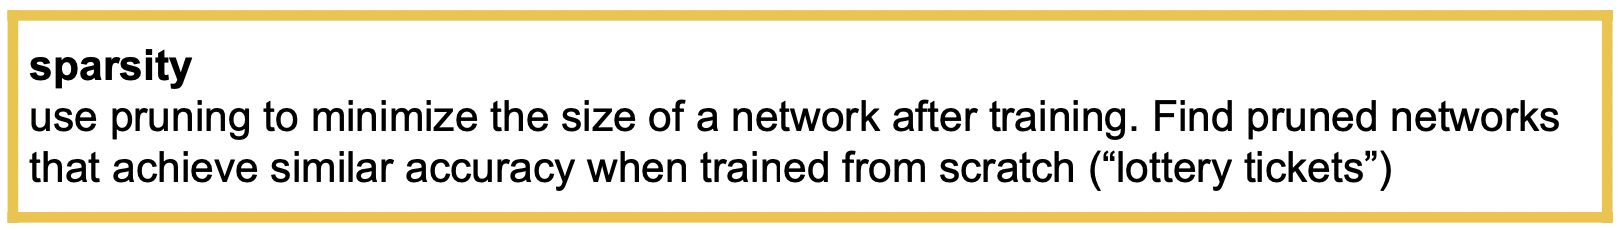

✅ Lets try to prune and fine tune this model:

ResNet was chosen due to the architecture - to try to prune usual CNN does not really make sense since it is way to simple for further simplification.

✅ Initialising our ResNet and training it on our dataset from scratch.

In [43]:
resnet_model = ResNetSmall(num_classes=2)
f1_original, trained_model = train_and_evaluate(resnet_model, train_loader, val_loader, labels, num_epochs=10)
print(f"F1-score for the original model: {f1_original:.4f}")


Epoch 1/10, Loss: 0.4070
Epoch 2/10, Loss: 0.1437
Epoch 3/10, Loss: 0.1287
Epoch 4/10, Loss: 0.1086
Epoch 5/10, Loss: 0.0625
Epoch 6/10, Loss: 0.0200
Epoch 7/10, Loss: 0.0103
Epoch 8/10, Loss: 0.0068
Epoch 9/10, Loss: 0.0053
Epoch 10/10, Loss: 0.0041
F1-score for the original model: 0.9524


✅ F1 0.9524 - considering this loss as BASELINE!!

✅ Losses from Epoch1 = 0.4070 to epoch 10. 0.0041


✅ Why Layer-Wise Pruning?

🫰🏻 Fair Distribution of Sparsity:
In global pruning, layers with more parameters might dominate the pruning process, while smaller layers are barely pruned.
Layer-Wise Pruning ensures every layer contributes fairly to sparsity.
Better Performance Preservation:
Each layer keeps a minimum number of parameters, preserving critical features across the network.

🫰🏻 We think that Global Pruning is too much, cause we want to keep the performance and contribution of each layer

🫰🏻 Pruning Criterion:
We use L1-norm pruning to remove weights with the smallest magnitude in each layer. These weights contribute the least to the output.

🫰🏻 Pruning Amount:
Each layer is pruned by the same percentage (e.g., 50%). This ensures consistent sparsity across all layers.

In [ ]:
def layer_wise_pruning(model, pruning_percentage=0.5):
    """ Pruning only conv and linear layers """
    print(f"Applying Layer-Wise Pruning with {pruning_percentage*100:.0f}% sparsity...")

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Pruning layer: {name} ({type(module).__name__})")
            prune.l1_unstructured(module, name="weight", amount=pruning_percentage)
            print(f"Number of pruned weights in {name}: {(module.weight == 0).sum().item()}")

    return model

In [ ]:
pruned_model = layer_wise_pruning(trained_model, pruning_percentage=0.5)

Applying Layer-Wise Pruning with 50% sparsity...
Pruning layer: conv1 (Conv2d)
Number of pruned weights in conv1: 288
Pruning layer: layer1.conv1 (Conv2d)
Number of pruned weights in layer1.conv1: 18432
Pruning layer: layer1.conv2 (Conv2d)
Number of pruned weights in layer1.conv2: 18432
Pruning layer: layer2.conv1 (Conv2d)
Number of pruned weights in layer2.conv1: 36864
Pruning layer: layer2.conv2 (Conv2d)
Number of pruned weights in layer2.conv2: 73728
Pruning layer: layer2.downsample.0 (Conv2d)
Number of pruned weights in layer2.downsample.0: 4096
Pruning layer: layer3.conv1 (Conv2d)
Number of pruned weights in layer3.conv1: 147456
Pruning layer: layer3.conv2 (Conv2d)
Number of pruned weights in layer3.conv2: 294912
Pruning layer: layer3.downsample.0 (Conv2d)
Number of pruned weights in layer3.downsample.0: 16384
Pruning layer: fc2 (Linear)
Number of pruned weights in fc2: 128
Pruning layer: fc1 (Linear)
Number of pruned weights in fc1: 6291456


✅ Pruning only Conv and Linear Layers - we have a bunch of them in ResNet - making sure sparsity is 50%

In [ ]:
def visualize_layer_wise_sparsity(model):
    """ Visualize sparsity """

    print("\nSparsity per layer:")
    total_params = 0
    total_zero_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total = module.weight.numel()
            zero = (module.weight == 0).sum().item()
            sparsity = zero / total * 100
            total_params += total
            total_zero_params += zero
            print(f"Layer {name}: {sparsity:.2f}% sparsity ({zero}/{total})")

    # Overall
    overall_sparsity = total_zero_params / total_params * 100
    print(f"\nOverall Model Sparsity: {overall_sparsity:.2f}%")

In [ ]:
visualize_layer_wise_sparsity(pruned_model)


Sparsity per layer:
Layer conv1: 50.00% sparsity (288/576)
Layer layer1.conv1: 50.00% sparsity (18432/36864)
Layer layer1.conv2: 50.00% sparsity (18432/36864)
Layer layer2.conv1: 50.00% sparsity (36864/73728)
Layer layer2.conv2: 50.00% sparsity (73728/147456)
Layer layer2.downsample.0: 50.00% sparsity (4096/8192)
Layer layer3.conv1: 50.00% sparsity (147456/294912)
Layer layer3.conv2: 50.00% sparsity (294912/589824)
Layer layer3.downsample.0: 50.00% sparsity (16384/32768)
Layer fc2: 50.00% sparsity (128/256)
Layer fc1: 50.00% sparsity (6291456/12582912)

Overall Model Sparsity: 50.00%


In [ ]:
def fine_tune_pruned_model(model, train_loader, val_loader, num_epochs=5, lr=0.001):

    """ Fine-tune the pruned model to restore accuracy.
    input:
        model: already pruned PyTorch model.
        Basically we retrain a pruned one again with an old function
    """
    print("\nFine-tuning the pruned model...")
    return train_and_evaluate(model, train_loader, val_loader, train_labels, num_epochs=num_epochs, lr=lr)


In [ ]:
f1_pruned, fine_tuned_model = fine_tune_pruned_model(pruned_model, train_loader, val_loader, num_epochs=5)
print(f"F1-score of the pruned one after the re-training: {f1_pruned:.4f}")


Fine-tuning the pruned model...
Epoch 1/5, Loss: 2.3178
Epoch 2/5, Loss: 0.4543
Epoch 3/5, Loss: 0.3404
Epoch 4/5, Loss: 0.2791
Epoch 5/5, Loss: 0.2226
F1-score обрезанной модели после дообучения: 0.9757


✅ Fine-Tuning the pruned model - basically retrain the pruned model using our old train_and_evaluate function:

✅ Loss from epoch1 - 2.3178 drops to 0.4543 on epoch2, and further to 0.2226 at epoch5.

✅ Final F1 on val set: 0.9757

✅ AS we see at the 1st epoch pruned ResNet shows a very high loss - this is what we expected since we have "cut" some branches and our model is "lost" in some way, but further it adjusts fast enough to the changes and shows us even better than original results. At the end we have the final F1 only 0.003 lower than the original ResNet which is perfect, we basically applied a kind of regularization in order to make a model more stable to overfitting and gave it the ability to generalize patterns better

In [ ]:
visualize_layer_wise_sparsity(fine_tuned_model)


Sparsity per layer:
Layer conv1: 50.00% sparsity (288/576)
Layer layer1.conv1: 50.00% sparsity (18432/36864)
Layer layer1.conv2: 50.00% sparsity (18432/36864)
Layer layer2.conv1: 50.00% sparsity (36864/73728)
Layer layer2.conv2: 50.00% sparsity (73728/147456)
Layer layer2.downsample.0: 50.00% sparsity (4096/8192)
Layer layer3.conv1: 50.00% sparsity (147456/294912)
Layer layer3.conv2: 50.00% sparsity (294912/589824)
Layer layer3.downsample.0: 50.00% sparsity (16384/32768)
Layer fc2: 50.00% sparsity (128/256)
Layer fc1: 50.00% sparsity (6291456/12582912)

Overall Model Sparsity: 50.00%


✊ Sparsity 50% confirmed again

In [ ]:
def reset_pruned_weights(model):
    """ Reset pruned weights to their original initialization (random initially). """
    print("\nResetting pruned weights to their original initialization...")
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")
    return model


In [ ]:
reinitialized_model = reset_pruned_weights(fine_tuned_model)
f1_lottery, lottery_model = train_and_evaluate(reinitialized_model, train_loader, val_loader, train_labels, num_epochs=10)
print(f"F1-score reinitialized model (LUCKY Lottery Ticket): {f1_lottery:.4f}")


Resetting pruned weights to their original initialization...
Epoch 1/10, Loss: 3.1980
Epoch 2/10, Loss: 0.0465
Epoch 3/10, Loss: 0.0124
Epoch 4/10, Loss: 0.0029
Epoch 5/10, Loss: 0.0008
Epoch 6/10, Loss: 0.0005
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0005
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0004
F1-score реинициализированной модели (Lottery Ticket): 0.9683


✅ The final F1 of the reinitialized (trained-pruned-finetuned-reinitialized pipeline) model is 0.9683 which is only 0.0077 lower than the BASELINE result.

🤟 As a result:

Baseline ResNet: F1-Score: 0.9760, this is the performance of the full model before pruning, which serves as the baseline for comparison.

Fine-Tuned Pruned Model: F1-Score: 0.9757. After pruning 50% of the weights and fine-tuning the pruned model, the F1-Score remains almost identical to the original model. This demonstrates that pruning successfully removed less important weights while retaining the network's capacity to perform well.

Lottery-ticket: F1-Score: 0.9683. After resetting the weights of the pruned model to their original initialization and training it from scratch, the model achieved a performance close to the original baseline. The slight drop in F1-Score is expected because the pruned network is smaller, but it still performs exceptionally well given the reduced number of parameters.

In [ ]:
def measure_inference_time(model, input_tensor, device, repetitions=100):

    model.to(device)
    model.eval()
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        _ = model(input_tensor)


    timings = []
    with torch.no_grad():
        for _ in range(repetitions):
            start_time = time.time()
            _ = model(input_tensor)
            end_time = time.time()
            timings.append(end_time - start_time)

    avg_inference_time = sum(timings) / len(timings) * 1000  # Convert to milliseconds
    return avg_inference_time


In [ ]:
def reinitialize_fc1(model, input_tensor):
    """
    Dynamically reinitialize the fc1 layer of the model to match the flattened size of the convolutional output.
    """
    model.eval()
    with torch.no_grad():
        # Pass the input tensor through the convolutional layers
        x = model.conv1(input_tensor)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)

        flattened_size = x.view(x.size(0), -1).size(1)

        model.fc1 = torch.nn.Linear(flattened_size, 128).to(input_tensor.device)
        print(f"Reinitialized fc1 with input size {flattened_size}.")

Reinitialized fc1 with input size 65536.
Output shape: torch.Size([1, 2])


In [ ]:
dummy_input = torch.randn(1, 1, 64, 64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = dummy_input.to(device)

reinitialize_fc1(trained_model, dummy_input)

with torch.no_grad():
    output = trained_model(dummy_input)
print("Output shape:", output.shape)

Reinitialized fc1 with input size 65536.
Output shape: torch.Size([1, 2])


In [ ]:
input_tensor = torch.randn(8, 1, 64, 64)  # batch 8
with torch.no_grad():
    output = trained_model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([8, 2])


In [ ]:
# batch size = 1, 1 channel, 64x64 spectrogram
input_tensor = torch.randn(1, 1, 64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inference_time_orig = measure_inference_time(trained_model, input_tensor, device, repetitions=100)
pruned_inference_time = measure_inference_time(fine_tuned_model, input_tensor, device, repetitions=100)
reinitialized_inference_time = measure_inference_time(lottery_model, input_tensor, device, repetitions=100)

print(f"Average Inference Time (Fine-Tuned Pruned Model): {pruned_inference_time:.2f} ms per batch")
print(f"Average Inference Time (Reinitialized Pruned Model): {reinitialized_inference_time:.2f} ms per batch")
print(f"Average Inference Time original: {inference_time_orig:.2f} ms per batch")

Average Inference Time (Fine-Tuned Pruned Model): 48.77 ms per batch
Average Inference Time (Reinitialized Pruned Model): 43.74 ms per batch
Average Inference Time original: 57.49 ms per batch


🫰🏻 As we see inference time improved sinificantly from 57.49 ms to 48.77 for the pruned model and even more to 43.74 ms for the reinitilized model (strange, but we can propose that reinitilization optimized sparsity or parameter distribution even further, dunno really). 14 ms save of inference time is a crazy good result since it's just a saved time for 1 batch, and in production it can change the business - also knowing the fact we lost only 0.0137 of our F1 score and 50% sparsity this makes it sound even better